In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture

import numpy as np

import pickle


In [19]:

df = pd.read_csv("../data/processed/sb_individual.csv")
player_data = df[['Player', 'League', 'Nation', 'Pos', 'Squad', 'Born', '90s']]
# Show full 90s played (not proportion)
player_data['90s'] = player_data['90s']

# Drop identifying columns
df.drop(columns = ['Unnamed: 0', 'Player', 'League', 'Nation', 'Pos', 'Squad', 'Born', '90s'], inplace=True)

# Add goal/assist stats to their own df
GA_stats = df[['Gls/90', 'np:G-xG', 
          'xA',  'onG', 'onGA', '+/-',
           'On-Off', 'onxG', 'onxGA', 'xG+/-', 'onG-xG', 'onGA-xGA', 'G-xG+/-' ]]
df.drop(columns = ['Gls/90', 'np:G-xG', 'Sh/90',
          'xA', 'xAG', 'A-xAG',  'onG', 'onGA', '+/-',
           'On-Off', 'onxG', 'onxGA', 'xG+/-', 'onG-xG', 'onGA-xGA', 'G-xG+/-'], inplace=True) # Removing data here is late addition

# Drop these columns in data collection
df.drop(columns = [ 'Mn/Start', 'Ast', 'Past', 'Starts', 'TimesOffside'], inplace=True)


/tmp/ipykernel_17653/3732056364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['90s'] = player_data['90s']


In [20]:
df.columns

Index(['AvgShotDist', 'npxG/90', 'npxG/Sh', 'TotDist/pass', 'PrgDist/Pass',
       'Short%', 'Med%', 'Long%', 'PropShort', 'PropMed', 'PropLong',
       'PropAssistShots', 'PropFinalThirdPasses', 'PropPassinPA',
       'PropCrossinPA', 'TotPassAtt', 'Sw', 'Crs', 'TI', 'PropPassBlocked',
       'Shot-Creating Pass/90', 'Shot-Creating Drib/90', 'Shot-CreatingSh/90',
       'Prop Def Pen Touches', 'Prop Def 3rd Touches', 'Prop Mid 3rd Touches',
       'Prop Att 3rd Touches', 'Prop Att Pen Touches', 'AttDribbles',
       'DribSucc%', 'RecPass/Misplayed', 'Dis', 'PropPassRecProg',
       'TotalTouches', 'Tkl', 'PropTkl Def 3rd', 'PropTkl Mid 3rd',
       'PropTkl Att 3rd', 'DribTkl', 'DribTkl%', 'Blocks', 'PropBlockSh',
       'PropBlockPass', 'Int', 'Clr', 'Fls', 'Fld', 'Recov', 'DuelWin%',
       'AerialDuels'],
      dtype='object')

In [3]:
# Add initial cluster stats to their own df
# initial_stats = df[['PassUnderPress', 'Sw', 'Crs', 'PropGround', 'PropLow', 'PropHigh', 'PropLeft', 'PropRight', 
# 'PropHead', 'TI', 'Off', 'PropOut', 'Targ', 'PropTkl Def 3rd', 'PropTkl Mid 3rd', 'PropTkl Att 3rd', 'PropPress Def 3rd', https://resume.creddle.io/resume/bc20zbepym6
# 'PropPress Mid 3rd', 'PropPress Att 3rd', 'PKwon', 'PKcon']]
# df.drop(columns = ['PassUnderPress', 'Sw', 'Crs', 'PropGround', 'PropLow', 'PropHigh', 'PropLeft', 'PropRight', 
# 'PropHead', 'TI', 'Off', 'PropOut', 'Targ', 'PropTkl Def 3rd', 'PropTkl Mid 3rd', 'PropTkl Att 3rd', 'PropPress Def 3rd', 
# 'PropPress Mid 3rd', 'PropPress Att 3rd', 'PKwon', 'PKcon'], inplace=True)

In [27]:
#Standard Scaling (scaling so data has mean of 0 and std dev of 1)

# Stats that are scaled were determined by inspecting initially processed data. Justification for scaling was:
# StandardScaler - Normal-like values with large magnitude 
# Min-MaxScaler - Non-normal relatively even distributions
# RobustScaler - data with large (albeit useful) outliers
stdscale_list = ['AvgShotDist', 'npxG/Sh', 'TotDist/pass', 'PrgDist/Pass', 'PropShort', 'PropMed', "PropLong", 'Long%', "PropFinalThirdPasses", 
    'TotPassAtt',  'TotalTouches', 'Tkl', 'PropTkl Def 3rd', 'PropTkl Mid 3rd', 'DribTkl',  'Blocks', 'Int',  'Fld', 'DribSucc%',
     'Recov', 'DuelWin%', 'DribTkl%', 'Prop Mid 3rd Touches']
minmax_list = ['Fls', 'Prop Def Pen Touches', 'Prop Att 3rd Touches', 'Prop Def 3rd Touches' ]
rbst_list = [] 
power_list = ['npxG/90', 'PropAssistShots', 'PropPassinPA', 'PropCrossinPA', 'Short%', 'Med%', "PropPassBlocked", "Dis",
    'Sw', 'Crs', 'Shot-CreatingSh/90', 'Shot-Creating Drib/90', 'Shot-Creating Pass/90',
     'Prop Att Pen Touches', 'AttDribbles',  'PropPassRecProg', 'PropTkl Att 3rd', 'PropBlockSh','PropBlockPass', 'Clr', 'AerialDuels', 
     'RecPass/Misplayed', 'TI']

## Need way to extract colunmns after transform (new order is transformed columns first, passthrough columns after)
original_df = df.copy()
original_df.drop(columns=stdscale_list, inplace=True)
original_df.drop(columns=minmax_list, inplace=True)
original_df.drop(columns=rbst_list, inplace=True)
original_df.drop(columns=power_list, inplace=True)

# Create list of column names with new order after transformations 
transformed_columns = stdscale_list + minmax_list + rbst_list + power_list + original_df.columns.to_list() 

#Do the transformations
cltr = ColumnTransformer(
    transformers =[('mean_scaling', StandardScaler(),stdscale_list  ),
    ('min-max_scaling', MinMaxScaler(), minmax_list  ),
    ("outlier_scaling", RobustScaler(), rbst_list  ),
    ("frequent_zeros", PowerTransformer(method='yeo-johnson'), power_list  )],
    remainder='passthrough')

df_trans = cltr.fit_transform(df)

# transform_data = {'Columns': transformed_columns, "Data": df_trans}
transform_data = [transformed_columns,  df_trans]
# Save the data to a different file for later reloading
pickle.dump(transform_data, open('../models/transformed_opta_data.p', "wb"))

In [5]:
print(df_trans[1])

[ 0.19593166 -0.82671035 -0.17000103  1.52626067  0.1601844  -0.02011518
  0.14623928 -1.25577442  0.43400307  0.45854859  0.8004481   0.03079624
  0.25026714 -0.56281593  0.60092712 -0.2049228   0.32325005  0.39948983
 -0.51328331  0.46319975  0.1885783   0.23945168  0.18767462  0.44311317
  0.90865385  0.03967746 -1.42143259 -0.09982711 -0.02177312  1.67958575
 -0.98265527 -0.81469001  0.07927882 -0.57309536 -0.18280977  0.67729397
 -1.38606721  0.36765102 -0.01590639 -0.04143875 -0.84037354 -0.02880738
 -0.2572885   0.55675091 -0.45485429  0.49583883  0.56748892  0.37616696
 -0.11802601  1.62235896]


In [6]:
print(df_trans.argmax()/77)

2064.2987012987014


In [24]:
transformed_columns

['AvgShotDist',
 'npxG/Sh',
 'TotDist/pass',
 'PrgDist/Pass',
 'PropShort',
 'PropMed',
 'PropLong',
 'Long%',
 'PropFinalThirdPasses',
 'TotPassAtt',
 'TotalTouches',
 'Tkl',
 'PropTkl Def 3rd',
 'PropTkl Mid 3rd',
 'DribTkl',
 'Blocks',
 'Int',
 'Fld',
 'Recov',
 'DuelWin%',
 'DribTkl%',
 'Fls',
 'Prop Def Pen Touches',
 'Prop Def 3rd Touches',
 'DribSucc%',
 'Prop Mid 3rd Touches',
 'npxG/90',
 'PropAssistShots',
 'PropPassinPA',
 'PropCrossinPA',
 'Short%',
 'Med%',
 'PropPassBlocked',
 'Dis',
 'Sw',
 'Crs',
 'Shot-CreatingSh/90',
 'Shot-Creating Drib/90',
 'Shot-Creating Pass/90',
 'Prop Att 3rd Touches',
 'Prop Att Pen Touches',
 'AttDribbles',
 'PropPassRecProg',
 'PropTkl Att 3rd',
 'PropBlockSh',
 'PropBlockPass',
 'Clr',
 'AerialDuels',
 'RecPass/Misplayed',
 'TI']

In [8]:
print(df_trans[173][0])

-1.6132355746446745


Low-dimensional dataset shape: (3496, 15)


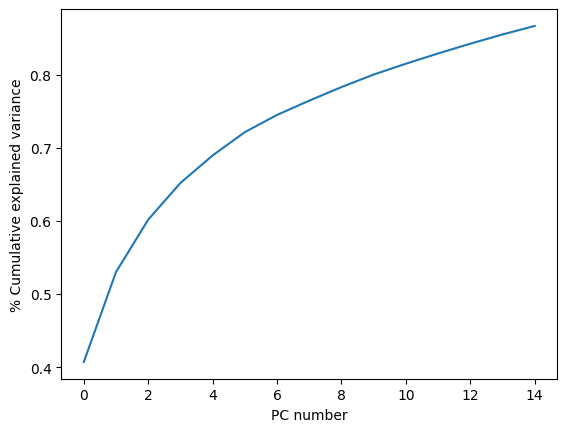

In [9]:
# Try some PCA

pca_compon = 15 # Number of PCA components
pca = PCA(n_components=pca_compon)
pca_data = pca.fit_transform(df_trans)

print('Low-dimensional dataset shape: {}'.format(pca_data.shape))

# See how well PCs explain variance in the dataset
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_variance)
plt.xlabel('PC number')
# plt.set_xticks()
plt.ylabel('% Cumulative explained variance')
plt.show()
##This is kind of unnecessary right now but whatever

# Find the loading matrix (relation between original features and principals compon) 
pca_cols = [f'PCA_{comp+1}' for comp in range(pca_compon) ]
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=pca_cols, index=transformed_columns)

# And then find the features that contribute largest magnitude to pca vectors

coeff = pca.components_


In [10]:
loading_matrix.sort_values(by='PCA_1', ascending=False).head(10)

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
Prop Att 3rd Touches,0.928300,-0.190119,-0.163984,0.022522,0.108999,0.015922,-0.020645,0.026480,-0.041071,-0.037177,-0.047670,0.031246,-0.010572,-0.032919,-0.018590
PropPassRecProg,0.908319,0.015207,-0.112054,-0.006670,0.024056,-0.034355,-0.040737,-0.001044,-0.029002,-0.077503,-0.029672,0.028067,0.019249,-0.016046,0.060769
PropAssistShots,0.899208,-0.076832,-0.119372,0.208121,-0.031379,-0.052784,-0.010595,0.043714,-0.038715,-0.060126,-0.050978,-0.003269,-0.004518,-0.038305,0.015352
Prop Att Pen Touches,0.869753,0.355360,-0.056680,0.033595,0.044660,-0.188358,0.027865,-0.012629,-0.001382,0.002497,-0.054160,0.042365,0.012106,0.012310,0.037453
Dis,0.835230,-0.209555,0.125389,-0.036245,-0.055102,-0.045423,0.191560,-0.118776,-0.065402,0.070381,0.025510,-0.009552,-0.006138,-0.008069,-0.028058
PropPassinPA,0.826056,-0.169360,-0.006756,0.156823,0.056581,-0.143615,-0.021144,0.036641,-0.047018,-0.139498,-0.031003,-0.013918,-0.077323,-0.092874,0.028485
PropBlockPass,0.794898,-0.331324,0.071208,-0.050016,0.008756,-0.008463,0.068681,0.186024,0.019490,-0.002755,0.055258,0.027287,0.304172,0.130139,-0.189562
npxG/90,0.789107,0.312729,0.125389,0.136945,0.090645,-0.360789,0.011242,0.036919,-0.057776,-0.031709,0.013128,0.036439,-0.039697,0.087644,0.028417
PropShort,0.788189,-0.003151,0.231954,-0.442174,0.053338,0.131149,-0.131797,-0.136244,-0.033030,-0.083721,0.034732,-0.055361,-0.046785,0.061873,0.029070
AttDribbles,0.757725,-0.383385,-0.050265,-0.060446,0.017543,-0.051867,0.265757,-0.144799,-0.126333,0.119091,-0.005706,-0.003590,0.017214,-0.031595,-0.017640


For n_clusters = any, the best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
For n_clusters = 2, the average silhouette_score is : 0.30; the Davies-Bouldin score is : 1.31; the Calinski-Harabsz score is 1904.06.
For n_clusters = 3, the average silhouette_score is : 0.26; the Davies-Bouldin score is : 1.38; the Calinski-Harabsz score is 1648.64.
For n_clusters = 4, the average silhouette_score is : 0.21; the Davies-Bouldin score is : 1.57; the Calinski-Harabsz score is 1344.70.
For n_clusters = 5, the average silhouette_score is : 0.22; the Davies-Bouldin score is : 1.65; the Calinski-Harabsz score is 1219.14.
For n_clusters = 6, the average silhouette_score is : 0.20; the Davies-Bouldin score is : 1.81; the Calinski-Harabsz score is 1038.64.
For n_clusters = 7, the average silhouette_score is : 0.15; the Davies-Bouldin score is : 2.01; the Calinski-Harabsz score is 901.17.
For n_clusters = 8, the average silhouette_score is : 0.15

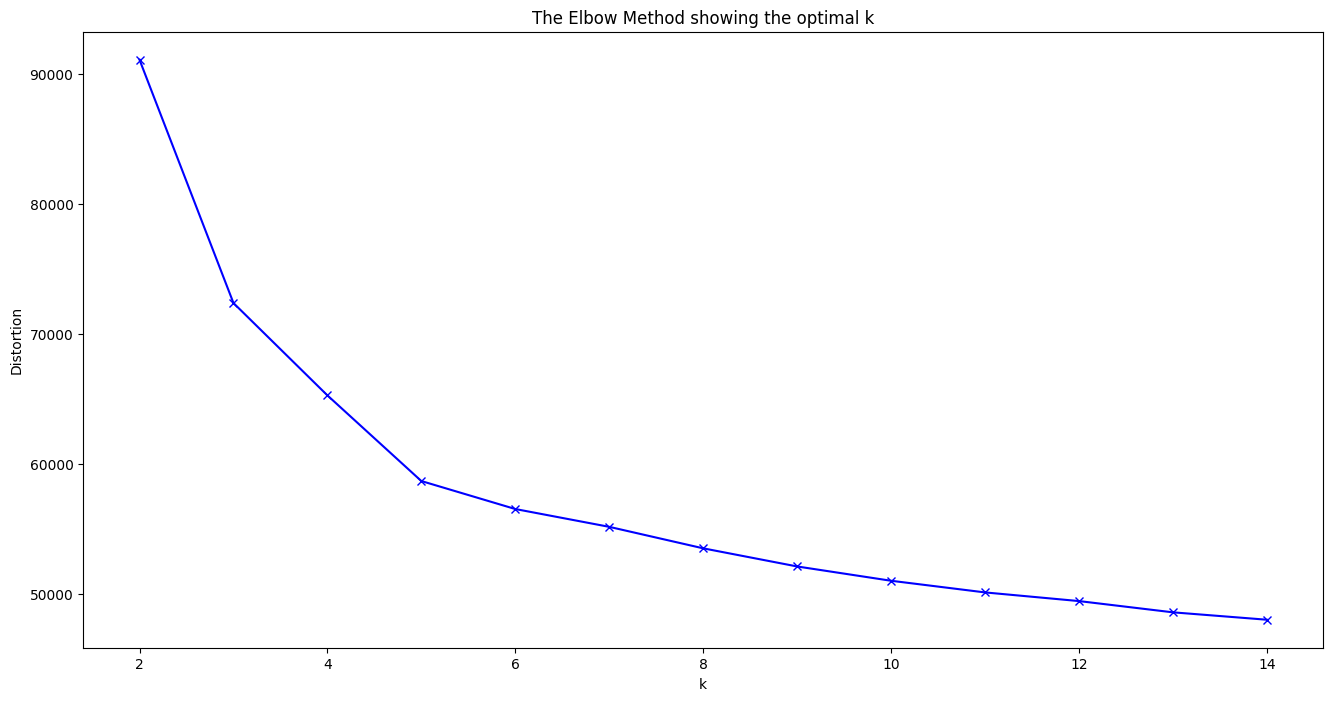

In [11]:
distortions = []
K = range(2,15)
    
print(f"For n_clusters = any, the best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_data)
    cluster_labels = kmeanModel.fit_predict(pca_data)
    distortions.append(kmeanModel.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters. Score ranges from -1 to 1, with 1 being best and -1 being worst.
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    
    # The Davies-Bouldin score shows clusters that are farther apart and less dispersed
    # Lower scores are better with 0 being best score
    db_score = davies_bouldin_score(pca_data, cluster_labels)
    
    # The Calinsi-Harabsz gives the ratio of between-cluster dispersion and within-cluster dispersion (...kind of).
    # The score is higher when clusters are well-separated (numerator) and dense (denominator)
    # So high scores are better.
    ch_score = calinski_harabasz_score(pca_data, cluster_labels)


    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
pca_compon = 12 # Number of PCA components
pca = PCA(n_components=pca_compon)
pca_data = pca.fit_transform(df_trans)

#Re-run cluster with best parameters
k_best = 8
kmeanModel = KMeans(n_clusters=k_best)
pca_kmean = kmeanModel.fit(pca_data)
cluster_labels = kmeanModel.fit_predict(pca_data)

pickle.dump(pca_kmean, open('../models/kmean_powertrans.p', "wb"))

In [13]:
# TODO:
# Silhouette, Rand, Dunn, Davies-Bouldin?, Inertia
# Also, Pickle it
# Also, match to validation stuff (positions from FBRef, Goal-scoring stuff?)

In [14]:
neighbors = 10
player_name = 'Domenico Criscito'

# Identify players who are most similar to a given player:
knn = NearestNeighbors(n_neighbors=neighbors)
knn.fit(pca_data)

# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one

idx = player_data[player_data['Player'] == player_name].index
print(idx)


Int64Index([1419, 1797], dtype='int64')


In [15]:
neighbor_idx = knn.kneighbors(pca_data[idx], return_distance=False)

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
1419,Domenico Criscito,Serie-A,ITA,DF,Genoa,1986.0,0.473684
3335,Omar Israel Mendoza,Liga-MX,MEX,DF,Querétaro,1988.0,0.741176
1944,Adam Lundqvist,Major-League-Soccer,SWE,DF,Houston Dynamo,1994.0,0.844118
1885,Aaron Herrera,Major-League-Soccer,USA,DF,Real Salt Lake,1997.0,0.741176
177,Iñigo Lekue,La-Liga,ESP,DF,Athletic Club,1993.0,0.563158
3263,Diego,Liga-MX,BRA,DF,Toluca,1988.0,0.332353
3395,Maximiliano Olivera,Liga-MX,URU,DF,FC Juárez,1992.0,0.832353
2515,José Carlos,Primeira-Liga,POR,DF,Gil Vicente FC,1998.0,0.802941
1978,Shaquell Moore,Major-League-Soccer,USA,DF,Nashville,1996.0,0.291176
2164,Graham Zusi,Major-League-Soccer,USA,DF,Sporting KC,1986.0,0.541176


In [16]:
similar_players2 = player_data.iloc[neighbor_idx[1], :]
similar_players2

,Player,League,Nation,Pos,Squad,Born,90s
1797,Domenico Criscito,Major-League-Soccer,ITA,DF,Toronto FC,1986.0,0.388235
422,Diogo Dalot,Premier-League,POR,DF,Manchester Utd,1999.0,0.526316
1998,Andy Najar,Major-League-Soccer,HON,DF,D.C. United,1993.0,0.544118
330,Kieran Trippier,La-Liga,ENG,DF,Atlético Madrid,1990.0,0.284211
2515,José Carlos,Primeira-Liga,POR,DF,Gil Vicente FC,1998.0,0.802941
2019,Diego Palacios,Major-League-Soccer,ECU,DF,Los Angeles FC,1999.0,0.785294
419,Marc Cucurella,Premier-League,ESP,DF,Brighton,1998.0,0.902632
2085,Pedro Santos,Major-League-Soccer,POR,DF,Columbus Crew,1988.0,0.761765
1205,Christopher Lenz,Bundesliga,GER,DF,Eint Frankfurt,1994.0,0.217647
1000,Djibril Sidibé,Ligue-1,FRA,DF,Monaco,1992.0,0.276316


In [17]:
pca_cols = [f'PCA_{comp+1}' for comp in range(pca_compon) ]
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
player_df = pd.DataFrame(pca_data, columns=pca_cols)
player_df['player'] = player_data['Player']

pca = PCA(n_components=9)
components = pca.fit_transform(pca_data)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    player_df, x='PCA_1', y='PCA_2', z='PCA_3', color=cluster_labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}, 
    hover_name = 'player'
)
fig.show()

NameError: name 'px' is not defined

Try affinity propagtion?


In [ ]:
from sklearn.cluster import AffinityPropagation



Or UMAP?

In [ ]:
import umap
import hdbscan


/home/marcjb/anaconda3/envs/player_analysis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=10,
    random_state=42,
).fit_transform(df_trans)

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(df_trans)
# plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral')

In [ ]:
hdb_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=20,
).fit_predict(clusterable_embedding)

In [ ]:
print(len(standard_embedding))

2167


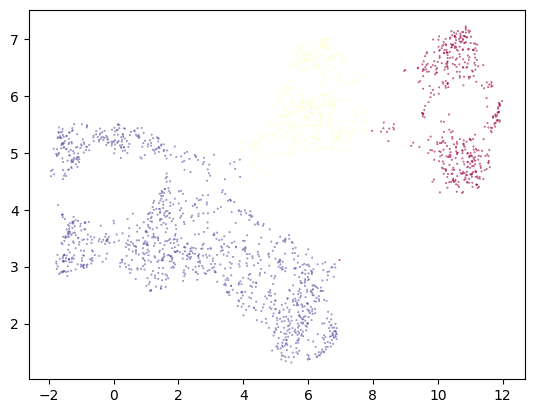

In [ ]:
clustered = (hdb_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdb_labels[clustered],
            s=0.1,
            cmap='Spectral')
plt.show()

In [ ]:
np.sum(clustered) / df_trans.shape[0]


1.0

In [ ]:

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
n_noise_ = list(hdb_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")

silhouette_avg = silhouette_score(df_trans, hdb_labels)

db_score = davies_bouldin_score(df_trans, hdb_labels)

ch_score = calinski_harabasz_score(df_trans, hdb_labels)

print(f"The average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")


Estimated number of clusters: 3
Estimated number of noise points: 0
The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
The average silhouette_score is : 0.14; the Davies-Bouldin score is : 1.91; the Calinski-Harabsz score is 515.63.


In [ ]:
from umap.umap_ import nearest_neighbors
# Identify players who are most similar to a given player:
# knn = NearestNeighbors(n_neighbors=6)
kneighbors = nearest_neighbors(standard_embedding,
                              n_neighbors = 10,
                              metric="minkowski",
                              metric_kwds=None,
                              angular=False,
                              random_state=None)


idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors[0][idx]

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
507,Harry Kane,Premier-League,ENG,FW,Tottenham,1993.0,0.944737
300,Oihan Sancet,La-Liga,ESP,FW,Athletic Club,2000.0,0.415789
557,Bryan Mbeumo,Premier-League,CMR,FW,Brentford,1999.0,0.850000
156,Luis Javier Suárez,La-Liga,COL,FW,Granada,1997.0,0.831579
1752,Brenner,Major-League-Soccer,BRA,FW,FC Cincinnati,2000.0,0.670588
369,Michail Antonio,Premier-League,JAM,FW,West Ham,1990.0,0.868421
1760,Cory Burke,Major-League-Soccer,JAM,FW,Philadelphia,1991.0,0.391176
1246,Karim Onisiwo,Bundesliga,AUT,FW,Mainz 05,1992.0,0.770588
38,Karim Benzema,La-Liga,FRA,FW,Real Madrid,1987.0,0.757895
1467,Manolo Gabbiadini,Serie-A,ITA,FW,Sampdoria,1991.0,0.334211


In [ ]:
hdb_labels

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
print(kneighbors[0])

[[   0  735    3 ...  375 1887 1944]
 [   1 1116 1298 ...   97 2143   14]
 [   2  941 1221 ... 1731 1242 1499]
 ...
 [2164 1882  911 ...   47 1898 2049]
 [2165 2082  567 ...  196  505 1620]
 [2166 1419 1755 ... 1946  580 1302]]


In [ ]:
idx

Int64Index([507], dtype='int64')

In [ ]:

player_name = 'Andrea Belotti'
idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors[0][idx]

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

,Player,League,Nation,Pos,Squad,Born,90s
1375,Andrea Belotti,Serie-A,ITA,FW,Torino,1993.0,0.400000
45,Ante Budimir,La-Liga,CRO,FW,Osasuna,1991.0,0.507895
1261,Sebastian Polter,Bundesliga,GER,FW,Bochum,1991.0,0.764706
1364,Keita Baldé,Serie-A,SEN,FW,Cagliari,1995.0,0.360526
712,Ludovic Ajorque,Ligue-1,REU,FW,Strasbourg,1994.0,0.800000
162,Joselu,La-Liga,ESP,FW,Alavés,1990.0,0.913158
1626,Antonio Sanabria,Serie-A,PAR,FW,Torino,1996.0,0.526316
244,Álvaro Negredo,La-Liga,ESP,FW,Cádiz,1985.0,0.631579
246,Fernando Niño,La-Liga,ESP,FW,Mallorca,2000.0,0.257895
2135,Brandon Vazquez,Major-League-Soccer,USA,FW,FC Cincinnati,1998.0,0.894118


Try Gaussian mixture with UMAP


In [ ]:
gm = GaussianMixture(n_components = 14, random_state=42)
gm_labels=gm.fit_predict(clusterable_embedding)


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(gm_labels)) - (1 if -1 in gm_labels else 0)
n_noise_ = list(gm_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.")

silhouette_avg = silhouette_score(df_trans, gm_labels)

db_score = davies_bouldin_score(df_trans, gm_labels)

ch_score = calinski_harabasz_score(df_trans, gm_labels)

print(f"The average silhouette_score is : {silhouette_avg:.2f}; the Davies-Bouldin score is : {db_score:.2f}; the Calinski-Harabsz score is {ch_score:.2f}.")


Estimated number of clusters: 14
Estimated number of noise points: 0
The best silhouette_score is : 1; the best Davies-Bouldin score is : 0; a good Calinski-Harabsz score is 1000.
The average silhouette_score is : 0.06; the Davies-Bouldin score is : 3.11; the Calinski-Harabsz score is 227.91.


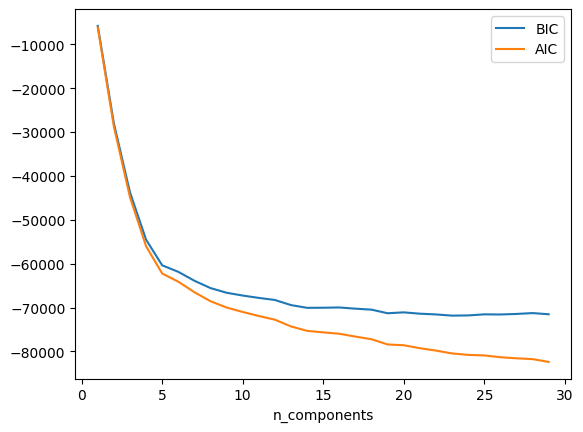

In [ ]:
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(clusterable_embedding) for n in n_components]
plt.plot(n_components, [m.bic(clusterable_embedding) for m in models], label='BIC')
plt.plot(n_components, [m.aic(clusterable_embedding) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [ ]:

# Identify players who are most similar to a given player:
knn = NearestNeighbors(n_neighbors=6)
kneighbors = nearest_neighbors.fit(standard_embedding)


idx = player_data[player_data['Player'] == player_name].index
# If player has changed leagues or teams, they'll be listed twice. Check for that...
# If more than one index, need to choose one
neighbor_idx = kneighbors(standard_embedding[idx], return_distance=False)

# Here, we can see similar players for both instances of an individual
similar_players1 = player_data.iloc[neighbor_idx[0], :]
similar_players1 

AttributeError: 'function' object has no attribute 'fit'